<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-09-06 17:31:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-09-06 17:31:51 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [6]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: | ^C
failed

CondaError: KeyboardInterrupt



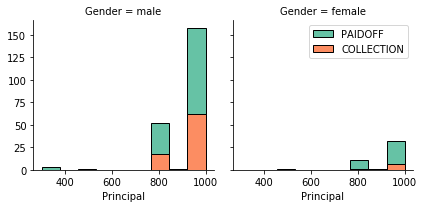

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

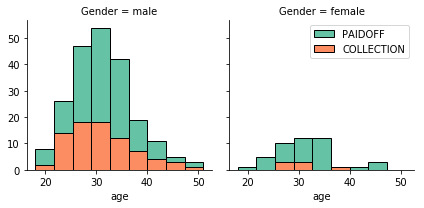

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

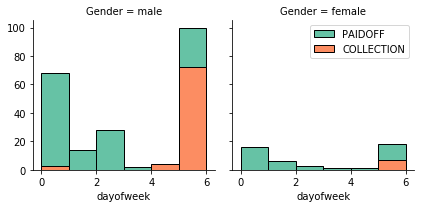

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 7)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

86 % of female pay there loans while only 73 % of males pay there loan


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Lets convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [139]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


### Feature selection

Lets defind feature sets, X:

In [140]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


What are our lables?

In [141]:
#df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [142]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [143]:
# Train test split the data to identify the best k value
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state =4) 
print('Size of the training set: ',X_train.shape, y_train.shape)
print('Size of the test set: ',X_val.shape, y_val.shape)

Size of the training set:  (276, 9) (276,)
Size of the test set:  (70, 9) (70,)


In [144]:
# import all packages required for k_NN algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
#from math import sqrt

In [145]:
# Choosing the best 'k' value to optimize the k-NN method
# Testing sequence of values from 1-10.
ks = 10

#declaring variables
acc_k = np.zeros((ks-1))
JI_k = np.zeros((ks-1))
train_k = np.zeros((ks-1))
std_k = np.zeros((ks-1))
F1_k = [0, 0]

#looping over different k values to train, predict and test accuracy of the algorithm
for k in range(1,ks):
    # train the algorithm
    k_class = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    # Using the trained model to predict it using test set
    y_pred = k_class.predict(X_val)
    # Find and store test accuracy for each value of 'k'
    # Using accuracy score
    acc_k[k-1] = metrics.accuracy_score(y_pred, y_val)
    #F1_score
    F1_k = np.vstack((F1_k,f1_score(y_val,y_pred, labels= ['PAIDOFF','COLLECTION'],average = None)))
    #Jaccard Index
    JI_k[k-1] = jaccard_similarity_score(y_pred,y_val)
    #standard deviation of the prediction for each value of k
    std_k[k-1] = np.std(y_pred==y_val)/np.sqrt(y_pred.shape[0])
    
    # Store Training set accuracy
    train_k[k-1] = metrics.accuracy_score(k_class.predict(X_train), y_train)
   



In [146]:
# Print the accuracy parameters
print('The training set accuracy score is:', train_k)
print('\n The accuracy score is:', acc_k)
print('\n The F1 Score is:', F1_k[1:])
print('\n The standard deviation of the error in prediction is:', std_k)

The training set accuracy score is: [0.89855072 0.82608696 0.83333333 0.8115942  0.81884058 0.79347826
 0.80072464 0.78985507 0.7826087 ]

 The accuracy score is: [0.67142857 0.58571429 0.72857143 0.7        0.77142857 0.71428571
 0.8        0.75714286 0.74285714]

 The F1 Score is: [[0.77227723 0.41025641]
 [0.69473684 0.35555556]
 [0.82242991 0.42424242]
 [0.79207921 0.46153846]
 [0.85185185 0.5       ]
 [0.80769231 0.44444444]
 [0.875      0.5       ]
 [0.83809524 0.51428571]
 [0.84482759 0.25      ]]

 The standard deviation of the error in prediction is: [0.05613914 0.05887676 0.05315141 0.05477226 0.05018915 0.05399492
 0.04780914 0.05125253 0.05223852]


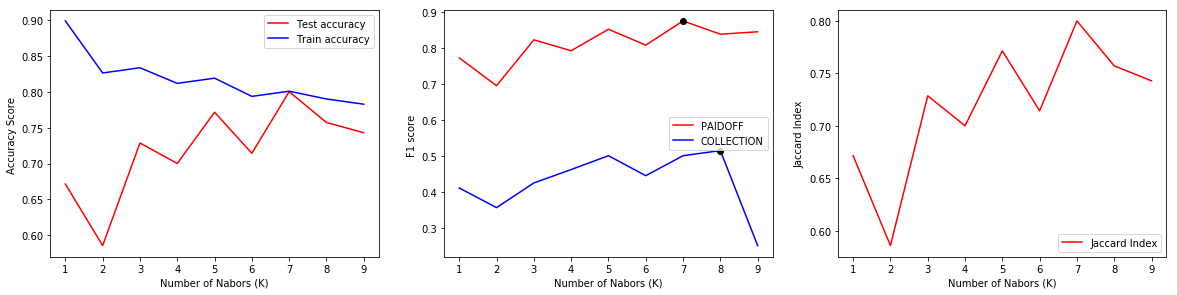

In [147]:
# Find max F1 score for each class
F1_max_index = np.where(F1_k == np.amax(F1_k, axis =0))


plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.plot(range(1,ks),acc_k,'r', label="Test accuracy")
plt.plot(range(1,ks),train_k,'b', label="Train accuracy")
#plt.fill_between(range(1,ks),acc_k - 1 * std_k,acc_k + 1 * std_k, alpha=0.10)
plt.ylabel('Accuracy Score ')
plt.xlabel('Number of Nabors (K)')
plt.legend(loc="upper right")
#plt.legend(label=['Test accuracy','Train accuracy'])
plt.subplot(2,3,2)
plt.plot(range(1,ks),F1_k[1:,0],'r', label="PAIDOFF")
plt.plot(range(1,ks),F1_k[1:,1],'b', label="COLLECTION")
plt.plot(F1_max_index[0],np.amax(F1_k, axis =0),'ko')
plt.ylabel('F1 score ')
plt.xlabel('Number of Nabors (K)')
plt.legend(loc="right")
plt.subplot(2,3,3)
plt.plot(range(1,ks),JI_k,'r', label="Jaccard Index")
plt.ylabel('Jaccard Index')
plt.xlabel('Number of Nabors (K)')
plt.legend(loc="lower right")
plt.show()

In [148]:
#  Choosing the best k value
# as both the error measurement parameter show the same trend, without overfitting,
# Average F1 score
mean_F1_knn =np.mean(F1_k, axis=1)
print('The F1 score is maximum for k=', mean_F1_knn.argmax())

#Choosing a trade-off between Jaccard index and F1 score, we choose k as
k=mean_F1_knn.argmax()

# Best fit model with k-NN algorithm
knn_class = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)


The F1 score is maximum for k= 7


In [24]:
np.mean(F1_k, axis=1)

array([0.        , 0.56190476, 0.61147086, 0.57575758, 0.615     ,
       0.63031998, 0.61154273, 0.65585054, 0.66298499, 0.60996395])

# Decision Tree

In [149]:
# importing the requried packages
from sklearn.tree import DecisionTreeClassifier
#declaring variables
ns = 10
m = 3
acc_y = np.zeros((ns-m))
train_acc_y = np.zeros((ns-m))
F1_y = [0, 0]
JI_y = np.zeros((ns-m))

for n in range(m,ns):
    #training the model for different max length of the tree
    tree_class = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    y_pred = tree_class.predict(X_val)
    
    #Accuracy estimation
    acc_y[n-m] = metrics.accuracy_score(y_pred,y_val)
    #Accuracy estimation on training data set
    train_y_pred = tree_class.predict(X_train)
    train_acc_y[n-m] = metrics.accuracy_score(train_y_pred,y_train)
    
    #F1_score
    F1_y = np.vstack((F1_y,f1_score(y_val,y_pred, labels= ['PAIDOFF','COLLECTION'],average = None)))
    #Jaccard Index
    JI_y[n-m] = jaccard_similarity_score(y_pred,y_val)

print('The training set accuracy score is:', acc_y)
print('\n The F1 Score is:', F1_y[1:])
print('\n The Jaccard Index is:', JI_y)

The training set accuracy score is: [0.61428571 0.61428571 0.64285714 0.77142857 0.75714286 0.75714286
 0.64285714]

 The F1 Score is: [[0.72727273 0.34146341]
 [0.72727273 0.34146341]
 [0.73684211 0.44444444]
 [0.86885246 0.11111111]
 [0.85950413 0.10526316]
 [0.85950413 0.10526316]
 [0.75247525 0.35897436]]

 The Jaccard Index is: [0.61428571 0.61428571 0.64285714 0.77142857 0.75714286 0.75714286
 0.64285714]


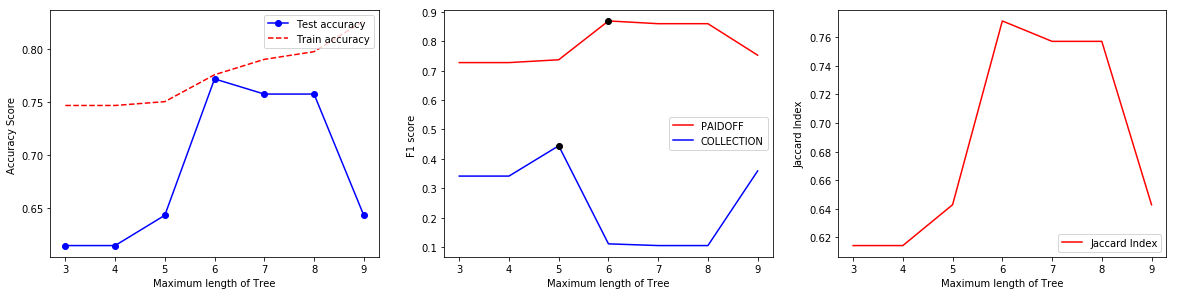

In [150]:
# Find max F1 score for each class
F1_max_index = np.where(F1_y == np.amax(F1_y, axis =0))

plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.plot(range(m,ns), acc_y, 'bo-',label ='Test accuracy')
plt.plot(range(m,ns), train_acc_y, 'r--',label ='Train accuracy')
plt.ylabel('Accuracy Score ')
plt.xlabel('Maximum length of Tree')
plt.legend(loc="upper right")
plt.subplot(2,3,2)
plt.plot(range(m,ns),F1_y[1:,0],'r', label="PAIDOFF")
plt.plot(range(m,ns),F1_y[1:,1],'b', label="COLLECTION")
plt.plot(np.where(F1_y[:,0] == np.amax(F1_y[:,0], axis =0))[0]+(m-1),np.amax(F1_y[:,0], axis =0),'ko')
plt.plot(np.where(F1_y[:,1] == np.amax(F1_y[:,1], axis =0))[0]+(m-1),np.amax(F1_y[:,1], axis =0),'ko')
plt.ylabel('F1 score ')
plt.xlabel('Maximum length of Tree')
plt.legend(loc="right")
plt.subplot(2,3,3)
plt.plot(range(m,ns),JI_y,'r', label="Jaccard Index")
plt.ylabel('Jaccard Index')
plt.xlabel('Maximum length of Tree')
plt.legend(loc="lower right")
plt.show()

In [151]:
#Since after max tree length of 6 the test accuracy reduces while train accuracy keeps increasing. 
#We can say that beyond tree depth of 6 the model might overfit.
#But the model performs poorly for 'COLLECTION' samples.
# we choose the tree length with highest average F1 score and 2nd best accuracy and J index
n = 5

print('The optimized max length of the tree is:',n)

The optimized max length of the tree is: 5


In [152]:
# Optimize decision tree is given by
tree_class = DecisionTreeClassifier(criterion ='entropy', max_depth = n).fit(X_train,y_train)


# Support Vector Machine

In [153]:
#Importing necessary packages
from sklearn import svm

In [154]:
# learning the model with training set
# Trying different kernels for best results

#Declaring variables
acc_ysm = np.zeros((3))
train_ac = np.zeros((3))
F1_svm =[0,0]
JI_svm = np.zeros((3))
i =0
list_kernels = ['linear', 'poly', 'rbf']

for ker in list_kernels:
    
    svm_class = svm.SVC(kernel = ker,degree = 3, gamma = 'scale').fit(X_train, y_train)
    # Use test set to predict
    y_pred = svm_class.predict(X_val)
    # Use test set to predict
    train_y_pred = svm_class.predict(X_train)
    
    acc_ysm[i] = metrics.accuracy_score(y_pred, y_val)
    train_ac[i]= metrics.accuracy_score(train_y_pred, y_train)
    
    #F1_score
    F1_svm = np.vstack((F1_svm,f1_score(y_val,y_pred, labels= ['PAIDOFF','COLLECTION'],average = None)))
    #Jaccard Index
    JI_svm[i] = jaccard_similarity_score(y_pred,y_val)
    i+=1



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [155]:
# the evaluation metrics
print('Accuracy score with training set: ', train_ac)
print('Accuracy score with test set: ', acc_ysm)
print('F1 sore with test set: \n', F1_svm[1:])
print('Jaccard index with test set: ', JI_svm)

Accuracy score with training set:  [0.74275362 0.7826087  0.77536232]
Accuracy score with test set:  [0.78571429 0.77142857 0.74285714]
F1 sore with test set: 
 [[0.88       0.        ]
 [0.86885246 0.11111111]
 [0.84210526 0.30769231]]
Jaccard index with test set:  [0.78571429 0.77142857 0.74285714]


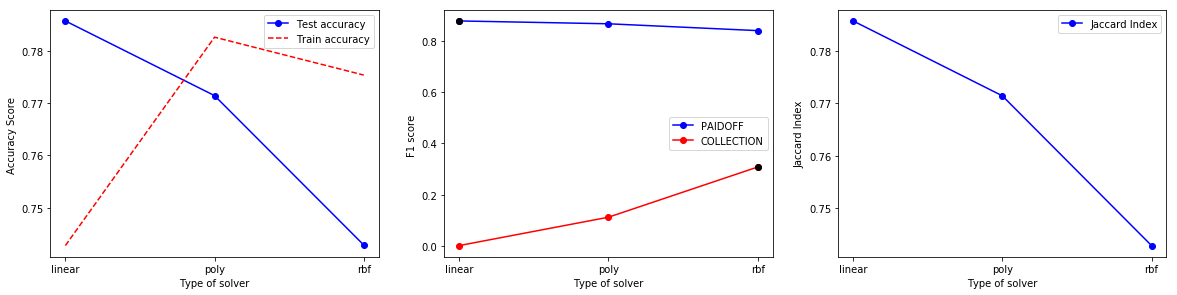

In [156]:
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.plot(['linear', 'poly', 'rbf'], acc_ysm, 'bo-', label ="Test accuracy")
plt.plot(['linear', 'poly', 'rbf'],train_ac, 'r--', label ="Train accuracy")
plt.ylabel('Accuracy Score ')
plt.xlabel('Type of solver')
plt.legend(loc="upper right")
plt.subplot(2,3,2)
plt.plot(['linear', 'poly', 'rbf'], F1_svm[1:,0], 'bo-', label ="PAIDOFF")
plt.plot(['linear', 'poly', 'rbf'], F1_svm[1:,1], 'ro-', label ="COLLECTION")
plt.plot(np.where(F1_svm[:,0] == np.amax(F1_svm[:,0], axis =0))[0]-1,np.amax(F1_svm[:,0], axis =0),'ko')
plt.plot(np.where(F1_svm[:,1] == np.amax(F1_svm[:,1], axis =0))[0]-1,np.amax(F1_svm[:,1], axis =0),'ko')
plt.ylabel('F1 score ')
plt.xlabel('Type of solver')
plt.legend(loc="right")
plt.subplot(2,3,3)
plt.plot(['linear', 'poly', 'rbf'], JI_svm, 'bo-', label="Jaccard Index")
plt.ylabel('Jaccard Index')
plt.xlabel('Type of solver')
plt.legend(loc="upper right")
plt.show()

In [159]:
mean_F1 = np.mean(F1_svm,axis=1).argmax()

# best F1 score is 
print('The best F1 score is for the solver ',list_kernels[mean_F1-1])
print('\n The mean F1 scoreis  ',np.mean(F1_svm,axis=1))

#Considering the F1 score we see that the linear solver do not perform well in labelling "COLLECTION" data set. 
# While "rbf" solver performing best as per F1 score, from poly to rbf the F1 score for "COLLECTION" label is doubled
# While accuracy is reduced only 3%
# Hence, "rbf" solver is the best solver to go ahead as the classifier

The best F1 score is for the solver  rbf

 The mean F1 scoreis   [0.         0.44       0.48998179 0.57489879]


In [178]:
# The best model using SVM for this particular data set is:
svm_class = svm.SVC(kernel ='rbf',degree = 3, gamma = 'scale').fit(X_train, y_train)


# Logistic Regression

In [161]:
# Using the same train and test data set split
# Importing the necessary libraries 
from sklearn.linear_model import LogisticRegression
#Log Loss
from sklearn.metrics import log_loss

In [162]:
# Building the model
# Declaring variables
c= [0.01,0.03, 0.1, 0.2, 0.3, 0.5, 1]

acc_ylr = np.zeros((len(c)))
acc_train1 = np.zeros((len(c)))
JI_lr = np.zeros((len(c)))
LL_lr = np.zeros((len(c)))
F1_lr = [0,0]

for i in range(0, len(c)):
    LR_class = LogisticRegression(C=c[i], solver ='liblinear').fit(X_train, y_train)
    y_pred = LR_class.predict(X_val)
    # Predict probability
    Y_probability = LR_class.predict_proba(X_val)

    # Estimating validation error
    acc_ylr[i] = metrics.accuracy_score(y_pred,y_val)
    acc_train1[i] = metrics.accuracy_score(LR_class.predict(X_train), y_train)
    
    #logloss
    LL_lr[i] = log_loss(y_val, Y_probability)
    #F1_score
    F1_lr = np.vstack((F1_lr,f1_score(y_val,y_pred, labels= ['PAIDOFF','COLLECTION'],average = None)))
    #Jaccard Index
    JI_lr[i] = jaccard_similarity_score(y_pred,y_val)




In [163]:
# the evaluation metrics
print('Accuracy score with training set: ',acc_train1)
print('Accuracy score with test set: ', acc_ylr)
print('F1 sore with test set: \n', F1_lr[1:])
print('Jaccard index with test set: ', JI_lr)
print('Log Loss with test set: ', LL_lr)

Accuracy score with training set:  [0.75724638 0.76449275 0.76449275 0.76811594 0.76449275 0.76811594
 0.76811594]
Accuracy score with test set:  [0.68571429 0.72857143 0.74285714 0.72857143 0.72857143 0.72857143
 0.72857143]
F1 sore with test set: 
 [[0.80701754 0.15384615]
 [0.83760684 0.17391304]
 [0.84745763 0.18181818]
 [0.83760684 0.17391304]
 [0.83760684 0.17391304]
 [0.83760684 0.17391304]
 [0.83760684 0.17391304]]
Jaccard index with test set:  [0.68571429 0.72857143 0.74285714 0.72857143 0.72857143 0.72857143
 0.72857143]
Log Loss with test set:  [0.57952831 0.53224196 0.51254146 0.51414512 0.51771868 0.52378921
 0.53344671]


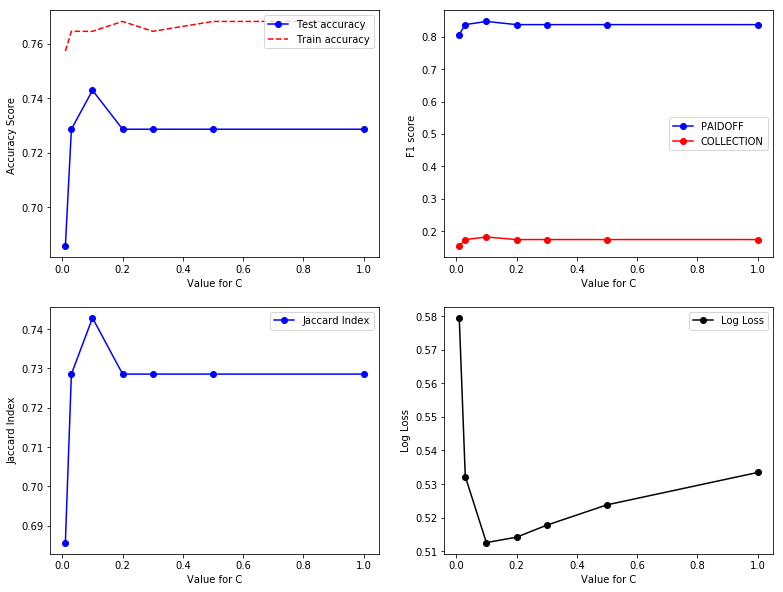

In [164]:
#Plot the accuracy and Jaccard index graph
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.plot(c, acc_ylr, 'bo-', label ="Test accuracy")
plt.plot(c,acc_train1, 'r--', label ="Train accuracy")
plt.ylabel('Accuracy Score ')
plt.xlabel('Value for C')
plt.legend(loc="upper right")
plt.subplot(2,3,2)
plt.plot(c, F1_lr[1:,0], 'bo-', label ="PAIDOFF")
plt.plot(c, F1_lr[1:,1], 'ro-', label ="COLLECTION")
#plt.plot(np.where(F1_lr[:,0] == np.amax(F1_lr[:,0], axis =0))[0]-1,np.amax(F1_lr[:,0], axis =0),'ko')
#plt.plot(np.where(F1_lr[:,1] == np.amax(F1_lr[:,1], axis =0))[0]-1,np.amax(F1_lr[:,1], axis =0),'ko')
plt.ylabel('F1 score ')
plt.xlabel('Value for C')
plt.legend(loc="right")
plt.subplot(2,3,4)
plt.plot(c,JI_lr, 'bo-', label="Jaccard Index")
plt.ylabel('Jaccard Index')
plt.xlabel('Value for C')
plt.legend(loc="upper right")
plt.subplot(2,3,5)
plt.plot(c,LL_lr, 'ko-', label="Log Loss")
plt.ylabel('Log Loss')
plt.xlabel('Value for C')
plt.legend(loc="upper right")
plt.show()


In [165]:
#average F1 score
mean_F1_LR = np.mean(F1_lr,axis=1)
#Ranking
print('Accuracy is highest for C =', c[acc_ylr.argmax()])
print('Average F1 score is highest for C =', c[mean_F1_LR.argmax()-1])
print('Jaccard index is highest for C =', c[JI_lr.argmax()])
print('Log loss is minimum for C =', c[LL_lr.argmin()])

Accuracy is highest for C = 0.1
Average F1 score is highest for C = 0.1
Jaccard index is highest for C = 0.1
Log loss is minimum for C = 0.1


In [166]:
# Best model is fit when the accuracy is max and the log loss is low
# Hence the best C value is
c= 0.1
print('Best value for C is:',c)

#Training the model again with the best value of C
LR_class = LogisticRegression(C=c, solver ='liblinear').fit(X_train, y_train)

Best value for C is: 0.1


# Model Evaluation using Test set

In [167]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

First, download and load the test set:

In [168]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-06 19:22:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-09-06 19:22:26 (314 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [169]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [170]:
# Transforming the data as the training set
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [171]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,50,1,0,1,0,0,0
1,300,7,35,0,1,0,0,1,0
2,1000,30,43,1,1,0,1,0,0
3,1000,30,26,0,1,0,0,0,1
4,800,15,29,0,1,1,0,0,0


In [172]:
test_X = test_Feature
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.19611614, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  5.09901951, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.19611614, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.19611614,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.19611614, -0.86135677]])

In [173]:
#df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [174]:
# Evaluation of k-NN, decision tree, SVM and Logistic regression algorithms
#Knn method
K_pred = knn_class.predict(test_X)

#Predict the accuracy
J_knn = jaccard_similarity_score(K_pred,test_y)
F1_knn = f1_score(test_y,K_pred, labels= ['PAIDOFF','COLLECTION'],average = None)

# Print accuracy
print('The Jaccard index for K-NN classification is: ', J_knn)
print('\n The F1 score for K-NN classification is:', F1_knn)
print('\n The average F1 score for K-NN classification is:', np.mean(F1_knn))

The Jaccard index for K-NN classification is:  0.6851851851851852

 The F1 score for K-NN classification is: [0.8045977  0.19047619]

 The average F1 score for K-NN classification is: 0.49753694581280783


In [175]:
# Decision Tree 
tree_pred = tree_class.predict(test_X)

#Predict the accuracy
J_tree = jaccard_similarity_score(tree_pred,test_y)
F1_tree = f1_score(test_y,tree_pred, labels= ['PAIDOFF','COLLECTION'],average = None)

# Print accuracy
print('The Jaccard index using Decision tree is: ', J_tree)
print('\n The F1 score using Decision tree is:', F1_tree)
print('\n The average F1 score using Decision tree is:', np.mean(F1_tree))

The Jaccard index using Decision tree is:  0.7592592592592593

 The F1 score using Decision tree is: [0.81690141 0.64864865]

 The average F1 score using Decision tree is: 0.7327750285496764


In [179]:
# SVM algorithm
svm_pred = svm_class.predict(test_X)

#Predict the accuracy
J_svm = jaccard_similarity_score(svm_pred,test_y)
F1_svm = f1_score(test_y,svm_pred, labels= ['PAIDOFF','COLLECTION'],average = None)

# Print accuracy
print('The Jaccard index for SVM algorithm is: ', J_svm)
print('\n The F1 score for SVM algorithm is:', F1_svm)
print('\n The average F1 score for SVM algorithm is:', np.mean(F1_svm))

The Jaccard index for SVM algorithm is:  0.7592592592592593

 The F1 score for SVM algorithm is: [0.85714286 0.23529412]

 The average F1 score for SVM algorithm is: 0.5462184873949579


In [177]:
#Logistic Regression Classification
LR_pred = LR_class.predict(test_X)
LR_probability = LR_class.predict_proba(test_X)

#Predict the accuracy
J_LR = jaccard_similarity_score(LR_pred,test_y)
F1_LR = f1_score(test_y,LR_pred, labels= ['PAIDOFF','COLLECTION'],average = None)
LL_LR = log_loss(test_y, LR_probability)

# Print accuracy
print('The Jaccard index for Logistic Regression is: ', J_LR)
print('\n The F1 score for Logistic Regression is:', F1_LR)
print('\n The average F1 score for Logistic Regression is:', np.mean(F1_LR))
print('\n The Log loss for Logistic Regression is:', LL_LR)

The Jaccard index for Logistic Regression is:  0.7592592592592593

 The F1 score for Logistic Regression is: [0.86021505 0.13333333]

 The average F1 score for Logistic Regression is: 0.4967741935483871

 The Log loss for Logistic Regression is: 0.4755615795456314


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7222  | 0.6464   | NA      |
| Decision Tree      | 0.7592  | 0.7327   | NA      |
| SVM                | 0.7963  | 0.6487   | NA      |
| LogisticRegression | 0.7592  | 0.4967   | 0.4777  |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>